In [ ]:
! pip -q install optax

     |████████████████████████████████| 140 kB 23.7 MB/s 
     |████████████████████████████████| 72 kB 703 kB/s 


In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit

%config InlineBackend.figure_format='retina'

In [ ]:
! git init .
! git remote add origin https://github.com/VLSF/SNO
! git pull origin main

In [ ]:
from functions import utils, Fourier, Chebyshev
from datasets import Burgers

Can generate solution in $x$-space.

In [ ]:
sol = Burgers.generate_trajectory(random.PRNGKey(9), smoothness="mid", cherry_pick=False, periodic=True, return_coeff=False)

In [ ]:
sol.shape

(300, 1001)

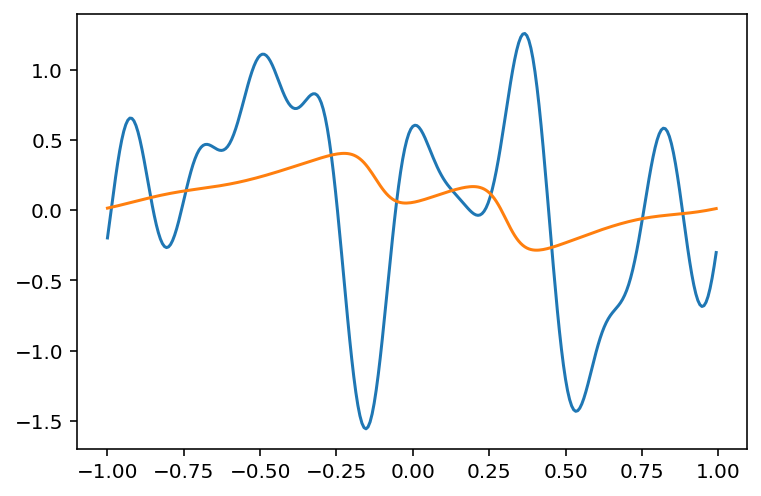

In [ ]:
plt.plot(utils.grid(300, periodic=True), sol[:, 0]);
plt.plot(utils.grid(300, periodic=True), sol[:, -1]);

Checking the residual with finite differences.

**this trajectory is subsampled in x-space, for the whole trajectory the residual is reasonable**

In [ ]:
n = 300
h = 0.0001 * 10
nu = 0.01
delta_x = 2/n
time_step = 9999
sol_dt = (sol[:, time_step+1] - sol[:, time_step-1]) / (2*h)
#sol_dx = (jnp.roll(sol[:, time_step]**2, -1) - jnp.roll(sol[:, time_step]**2, 1)) / (2*delta_x)
sol_dx = (jnp.roll(sol[:, time_step]**2, -1)*2/3 - jnp.roll(sol[:, time_step]**2, -2)/12  - jnp.roll(sol[:, time_step]**2, 1)*2/3 + jnp.roll(sol[:, time_step]**2, +2)/12) / delta_x
sol_d2x = (jnp.roll(sol[:, time_step], 1) + jnp.roll(sol[:, time_step], -1) - 2*sol[:, time_step]) / (delta_x**2)
res = jnp.linalg.norm(sol_dt + sol_dx / 2 - sol_d2x*nu) / jnp.linalg.norm(sol[:, time_step])
print(res)

1.0860280351996607


In [ ]:
sol = Burgers.generate_trajectory(random.PRNGKey(9), smoothness="high", cherry_pick=False, periodic=True, return_coeff=False)

n = 300
h = 0.0001 * 10
nu = 0.1
delta_x = 2/n
time_step = 9999
sol_dt = (sol[:, time_step+1] - sol[:, time_step-1]) / (2*h)
#sol_dx = (jnp.roll(sol[:, time_step]**2, -1) - jnp.roll(sol[:, time_step]**2, 1)) / (2*delta_x)
sol_dx = (jnp.roll(sol[:, time_step]**2, -1)*2/3 - jnp.roll(sol[:, time_step]**2, -2)/12  - jnp.roll(sol[:, time_step]**2, 1)*2/3 + jnp.roll(sol[:, time_step]**2, +2)/12) / delta_x
sol_d2x = (jnp.roll(sol[:, time_step], 1) + jnp.roll(sol[:, time_step], -1) - 2*sol[:, time_step]) / (delta_x**2)
res = jnp.linalg.norm(sol_dt + sol_dx / 2 - sol_d2x*nu) / jnp.linalg.norm(sol[:, time_step])
print(res)

0.7771484373785101


We can also generate solution in a form of Chebyshev or Fourier coefficint.

In [ ]:
sol_f = Burgers.generate_trajectory(random.PRNGKey(9), smoothness="mid", cherry_pick=False, periodic=True, return_coeff=True)
sol_Ch = Burgers.generate_trajectory(random.PRNGKey(9), smoothness="mid", cherry_pick=False, periodic=False, return_coeff=True)

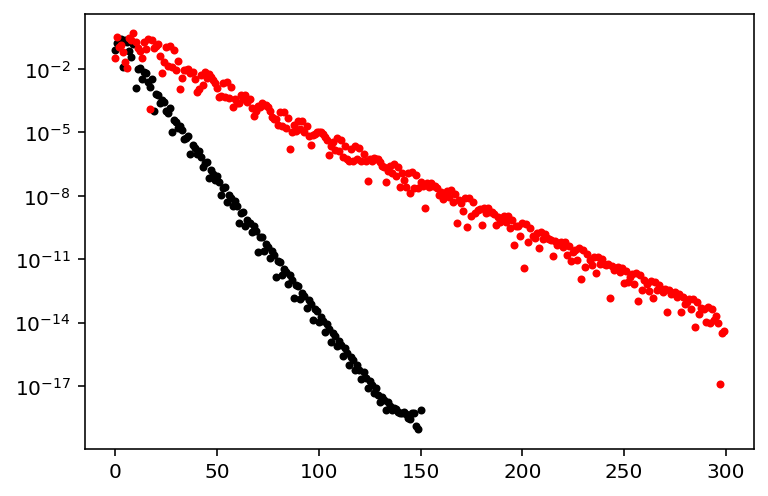

In [ ]:
plt.yscale("log")
plt.plot(abs(sol_f[:, 5]), ".", color="black")
plt.plot(abs(sol_Ch[:, 5]), ".", color="red");

There is a function that generates all useful datasets.

In [ ]:
Burgers.generate_Burgers_dataset(4, random.PRNGKey(9), smoothness="low")

In [ ]:
! ls

architectures
Chebyshev_coeff_Burgers_low_smoothness.npy
code.zip
datasets
experiments
Fourier_coeff_Burgers_low_smoothness.npy
functions
__MACOSX
sample_data
Uniform_grid_Burgers_low_smoothness.npy


In [ ]:
Fourier_Burgers = jnp.load("Fourier_coeff_Burgers_low_smoothness.npy")
Uniform_Burgers = jnp.load("Uniform_grid_Burgers_low_smoothness.npy")
Chebyshev_Burgers = jnp.load("Chebyshev_coeff_Burgers_low_smoothness.npy")

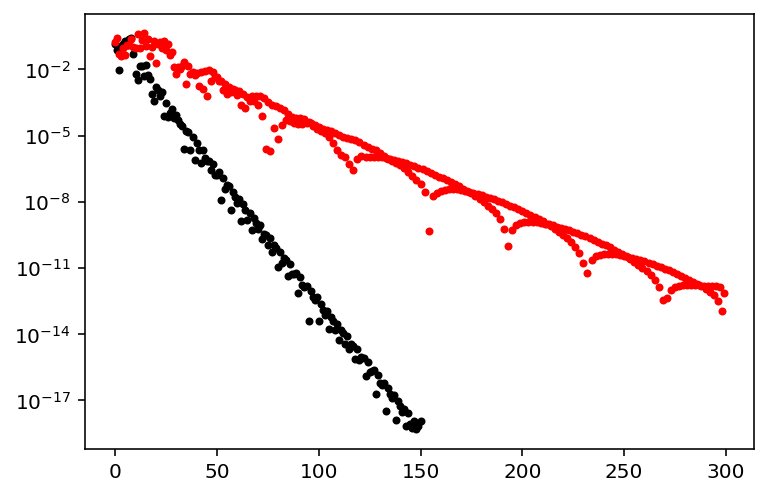

In [ ]:
plt.yscale("log")
plt.plot(abs(Fourier_Burgers[:, 5, 0]), ".", color="black")
plt.plot(abs(Chebyshev_Burgers[:, 5, 0]), ".", color="red");

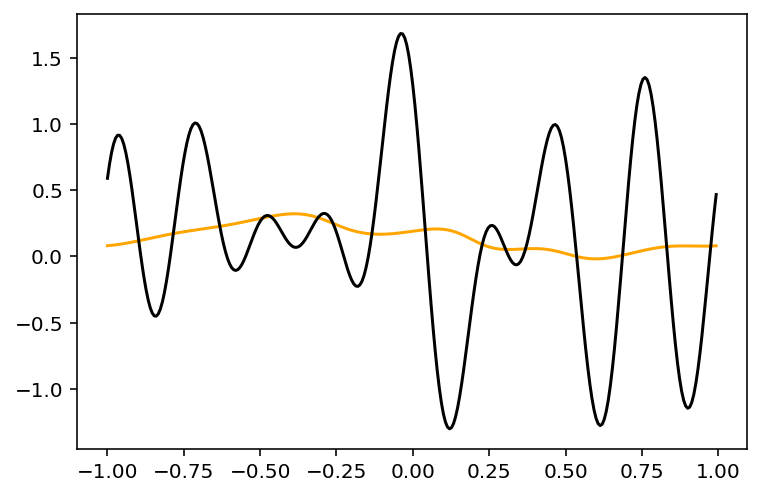

In [ ]:
x = utils.grid(300, periodic=True)
plt.plot(x, Uniform_Burgers[:, -1, 0], color="orange")
plt.plot(x, Uniform_Burgers[:, 0, 0], color="black");

## How many modes is enough to predict accurate solution?

### High smoothness

In [ ]:
n = 20
keys = random.split(random.PRNGKey(9), n)
sol = []
for i in range(n):
  sol_f = Burgers.generate_trajectory(keys[i], smoothness="high", cherry_pick=False, periodic=True, return_coeff=True)
  sol.append(sol_f[:100, -1])
data = jnp.stack(sol, -1).T

In [ ]:
errors = jnp.array([jnp.mean(jnp.linalg.norm(data[:, :i], axis=1) / jnp.linalg.norm(data[:, :], axis=1)) for i in range(1, 30)])
modes = jnp.linspace(1, 29, 29)

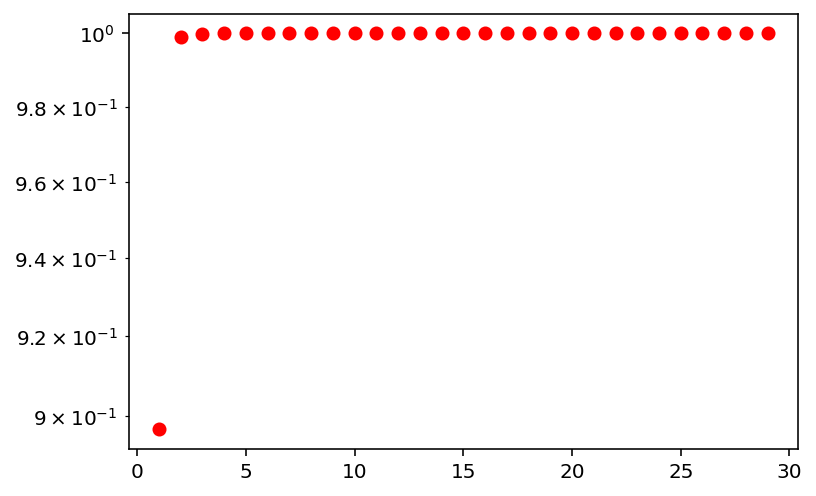

In [ ]:
plt.yscale("log")
plt.plot(modes, errors, "o", color="red");

Errors in $x$-space.

In [ ]:
exact_data = Fourier.coefficients_to_values(data[:, :].T, (100, 1)).T
exact_norms = jnp.linalg.norm(exact_data, axis=1)
errors = []
for i in range(1, 30):
  truncated_data = Fourier.coefficients_to_values(data[:, :i].T, (100, 1)).T
  error = jnp.mean(jnp.linalg.norm(exact_data - truncated_data, axis=1) / exact_norms)
  errors.append(error)

errors = jnp.array(errors)

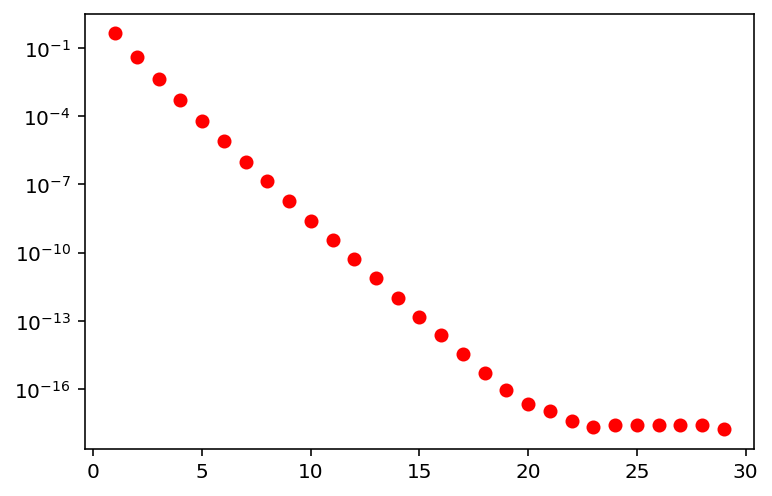

In [ ]:
plt.yscale("log")
plt.plot(modes, errors, "o", color="red");

The same story but for Chebyshev.

In [ ]:
n = 20
keys = random.split(random.PRNGKey(9), n)
sol = []
for i in range(n):
  sol_f = Burgers.generate_trajectory(keys[i], smoothness="high", cherry_pick=False, periodic=False, return_coeff=True)
  sol.append(sol_f[:100, -1])
data = jnp.stack(sol, -1).T

In [ ]:
errors = jnp.array([jnp.mean(jnp.linalg.norm(data[:, :i], axis=1) / jnp.linalg.norm(data[:, :], axis=1)) for i in range(1, 30)])
modes = jnp.linspace(1, 29, 29)

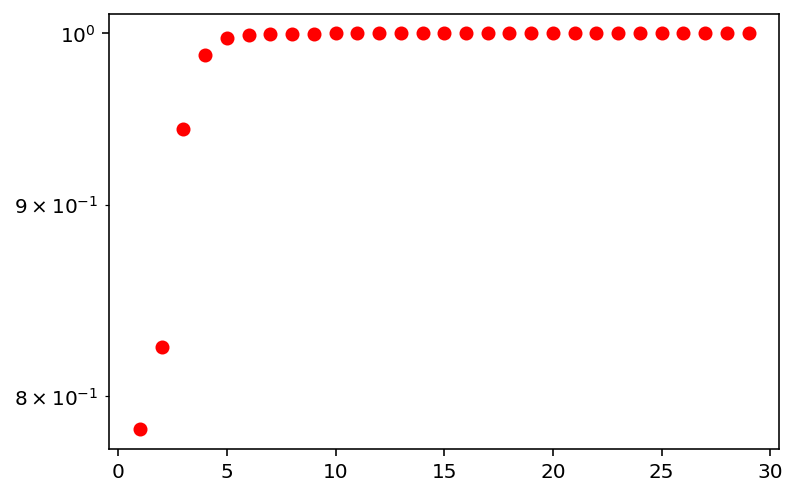

In [ ]:
plt.yscale("log")
plt.plot(modes, errors, "o", color="red");

Errors in $x$-space.

In [ ]:
exact_data = Chebyshev.coefficients_to_values(data[:, :].T).T
exact_norms = jnp.linalg.norm(exact_data, axis=1)
errors = []
for i in range(1, 50):
  truncated_data = Chebyshev.coefficients_to_values(jnp.pad(data[:, :i], ((0, 0), (0, 100-i))).T).T
  error = jnp.mean(jnp.linalg.norm(exact_data - truncated_data, axis=1) / exact_norms)
  errors.append(error)

errors = jnp.array(errors)

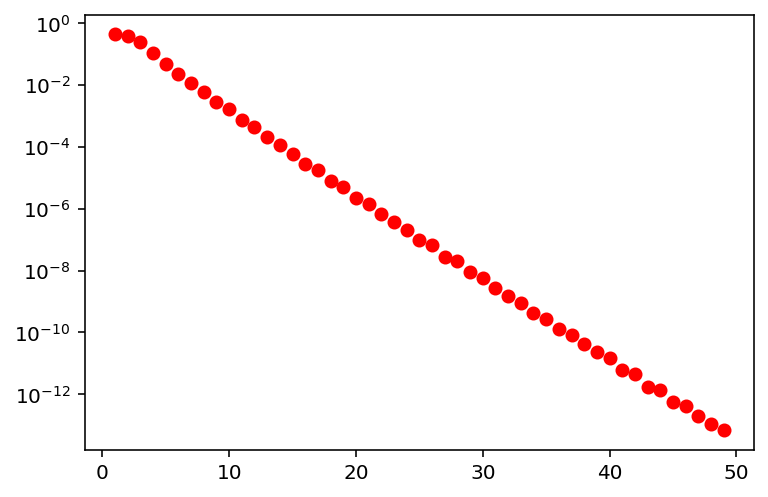

In [ ]:
plt.yscale("log")
plt.plot(range(1, 50), errors, "o", color="red");

### Low smoothness

In [ ]:
n = 20
keys = random.split(random.PRNGKey(9), n)
sol = []
for i in range(n):
  sol_f = Burgers.generate_trajectory(keys[i], smoothness="low", cherry_pick=False, periodic=True, return_coeff=True)
  sol.append(sol_f[:100, -1])
data = jnp.stack(sol, -1).T

In [ ]:
errors = jnp.array([jnp.mean(jnp.linalg.norm(data[:, :i], axis=1) / jnp.linalg.norm(data[:, :], axis=1)) for i in range(1, 30)])
modes = jnp.linspace(1, 29, 29)

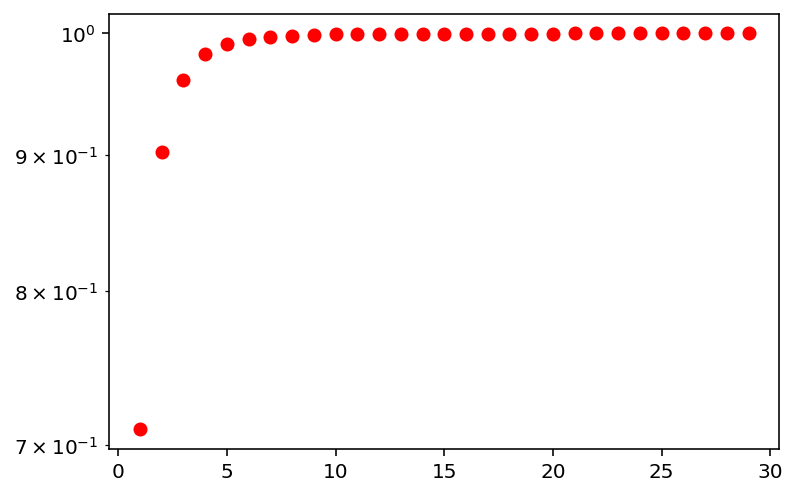

In [ ]:
plt.yscale("log")
plt.plot(modes, errors, "o", color="red");

Errors in $x$-space.

In [ ]:
exact_data = Fourier.coefficients_to_values(data[:, :].T, (100, 1)).T
exact_norms = jnp.linalg.norm(exact_data, axis=1)
errors = []
for i in range(1, 30):
  truncated_data = Fourier.coefficients_to_values(data[:, :i].T, (100, 1)).T
  error = jnp.mean(jnp.linalg.norm(exact_data - truncated_data, axis=1) / exact_norms)
  errors.append(error)

errors = jnp.array(errors)

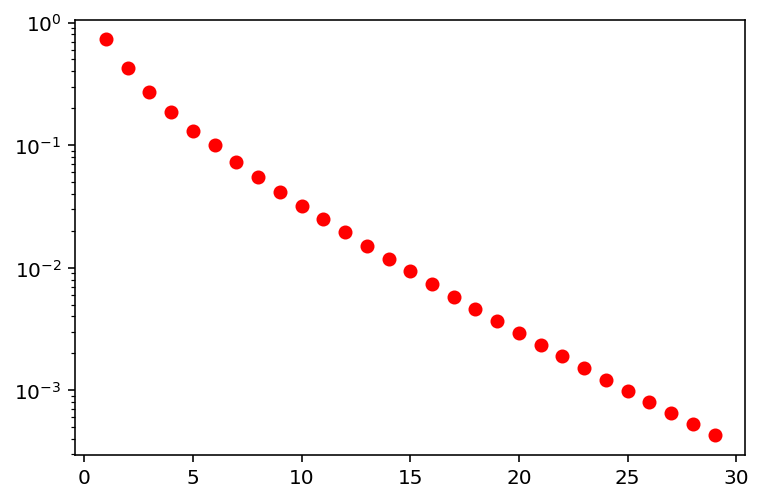

In [ ]:
plt.yscale("log")
plt.plot(modes, errors, "o", color="red");

The same story but for Chebyshev.

In [ ]:
n = 20
keys = random.split(random.PRNGKey(9), n)
sol = []
for i in range(n):
  sol_f = Burgers.generate_trajectory(keys[i], smoothness="low", cherry_pick=False, periodic=False, return_coeff=True)
  sol.append(sol_f[:100, -1])
data = jnp.stack(sol, -1).T

In [ ]:
errors = jnp.array([jnp.mean(jnp.linalg.norm(data[:, :i], axis=1) / jnp.linalg.norm(data[:, :], axis=1)) for i in range(1, 30)])
modes = jnp.linspace(1, 29, 29)

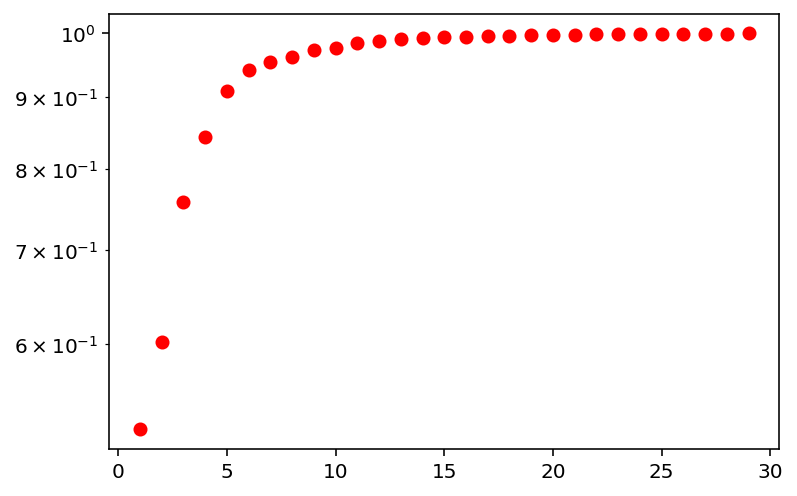

In [ ]:
plt.yscale("log")
plt.plot(modes, errors, "o", color="red");

Errors in $x$-space.

In [ ]:
exact_data = Chebyshev.coefficients_to_values(data[:, :].T).T
exact_norms = jnp.linalg.norm(exact_data, axis=1)
errors = []
for i in range(1, 50):
  truncated_data = Chebyshev.coefficients_to_values(jnp.pad(data[:, :i], ((0, 0), (0, 100-i))).T).T
  error = jnp.mean(jnp.linalg.norm(exact_data - truncated_data, axis=1) / exact_norms)
  errors.append(error)

errors = jnp.array(errors)

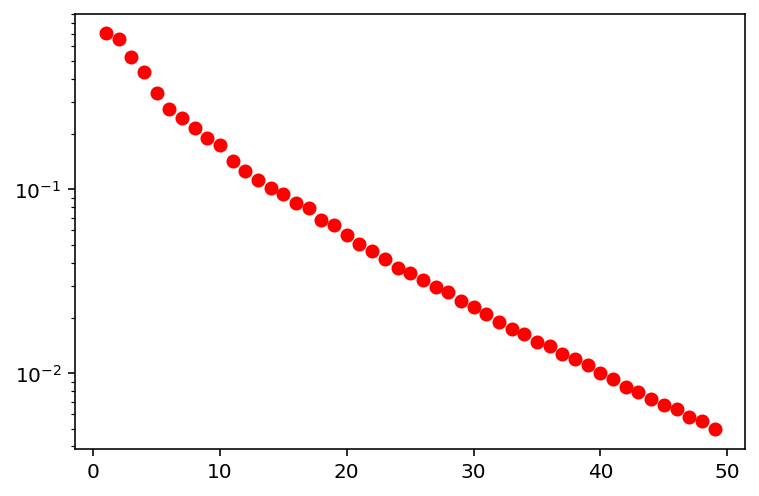

In [ ]:
plt.yscale("log")
plt.plot(range(1, 50), errors, "o", color="red");